In [1]:
from __future__ import division
import numpy as np
import os
import glob

In [2]:
from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
# %matplotlib inline

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Lambda, ELU, Activation, BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

In [4]:
from keras.optimizers import SGD, Adam,RMSprop
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
from keras.layers import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D

In [6]:
#These are the forms in the dataset for quick access from manipulation of the file names drive.mount('/content/gdrive')
d = {}
from subprocess import check_output
with open('/content/gdrive/My Drive/forms_for_parsing.txt') as f:
  for line in f:
      key = line.split(' ')[0]
      writer = line.split(' ')[1]
      d[key] = writer
print("length of the dictionary: ",len(d.keys()))

length of the dictionary:  1539


(4992,)
(4992,)


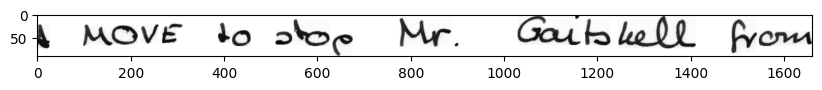

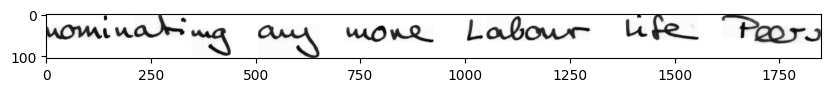

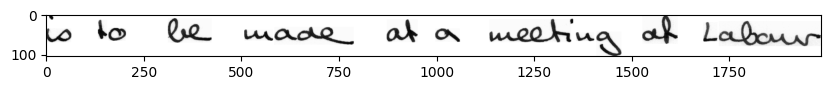

In [7]:
# All file-names list and target-writer names list are created.
tmp = []

target_list = []
path_to_files = os.path.join('/content/gdrive/My Drive/data_subset','*')
for filename in sorted(glob.glob(path_to_files)):
# print(filename)
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)


# visualize the image data
for filename in img_files[:3]:
  img=mpimg.imread(filename)
  plt.figure(figsize=(10,10))
  plt.imshow(img, cmap ='gray')

In [8]:
for filename in sorted(glob.glob(path_to_files)):
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    if len(parts) >= 2:  # Make sure there are at least two parts
        form = parts[0] + '-' + parts[1]
        for key in d:
            if key == form:
                target_list.append(str(d[form]))
    else:
        print(f"Skipping file {filename} because it doesn't follow the expected naming convention.")


In [9]:
# normalisation is done using label encoder. No, categorical data.
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)
print(img_files[:10], img_targets[:10], encoded_Y[:10])

['/content/gdrive/My Drive/data_subset/a01-000u-s00-00.png'
 '/content/gdrive/My Drive/data_subset/a01-000u-s00-01.png'
 '/content/gdrive/My Drive/data_subset/a01-000u-s00-02.png'
 '/content/gdrive/My Drive/data_subset/a01-000u-s00-03.png'
 '/content/gdrive/My Drive/data_subset/a01-000u-s01-00.png'
 '/content/gdrive/My Drive/data_subset/a01-000u-s01-01.png'
 '/content/gdrive/My Drive/data_subset/a01-000u-s01-02.png'
 '/content/gdrive/My Drive/data_subset/a01-000u-s01-03.png'
 '/content/gdrive/My Drive/data_subset/a01-003u-s00-00.png'
 '/content/gdrive/My Drive/data_subset/a01-003u-s00-01.png'] ['000' '000' '000' '000' '000' '000' '000' '000' '000' '000'] [0 0 0 0 0 0 0 0 0 0]


In [10]:
# Splitting of data into training and validation sets for cross validation with 4:1:1
train_files, rem_files, train_targets, rem_targets = train_test_split(
img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)
validation_files, test_files, validation_targets, test_targets = train_test_split(
rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)
print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3294,) (849,) (849,)
(3294,) (849,) (849,)


In [11]:
# Generator function for generating random crops from each sentence randomly cropping 113*113 patches from images
batch_size = 16
num_classes = 50
def generate_data(samples, target_files, batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
      for offset in range(0, num_samples, batch_size):
        batch_samples = samples[offset:offset+batch_size]
        batch_targets = target_files[offset:offset+batch_size]

        images = []
        targets = []
        for i in range(len(batch_samples)):
          batch_sample = batch_samples[i]
          batch_target = batch_targets[i]
          im = Image.open(batch_sample)
          cur_width = im.size[0]
          cur_height = im.size[1]
          # print(cur_width, cur_height)

          height_fac = 113 / cur_height
          new_width = int(cur_width * height_fac)
          size = new_width, 113

          imresize = im.resize((size), Image.ANTIALIAS) # Resize so height = 113 while keeping aspect ratio
          now_width = imresize.size[0]
          now_height = imresize.size[1]
          # Generate crops of size 113x113 from this resized image and keep random 10% of crops

          avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

          # Pick random x%
          pick_num = int(len(avail_x_points)*factor)

          # Now pick
          random_startx = sample(avail_x_points, pick_num)

          for start in random_startx:
              imcrop = imresize.crop((start, 0, start+113, 113))
              images.append(np.asarray(imcrop))
              targets.append(batch_target)

        #trim image to only see section with road
        X_train = np.array(images)
        y_train = np.array(targets)

        #reshape X_train for feeding in later
        X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
        #convert to float and normalize
        X_train = X_train.astype('float32')
        X_train /= 255

        #One hot encode y
        y_train = to_categorical(y_train, num_classes)
        yield shuffle(X_train, y_train)

# For training and testing, generator function is called with the intent of making train and test generator data.
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)


In [12]:
# A Keras Model is built. Summary of the model is printed below.
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize(image,[56,56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image)) #resize images to allow for easy computation

# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2')) #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters=128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3')) #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, name='dense1')) #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64, name='dense2')) #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax')) #softmax since output is within 50 classes
print("Worked till here")

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

print(model.summary())

Worked till here
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 115, 115, 1)       0         
 g2D)                                                            
                                                                 
 lambda (Lambda)             (None, 56, 56, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 32)        832       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                       

In [13]:
# Training the Model
nb_epoch = 2

samples_per_epoch = 8
nb_val_samples = 62

# #save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
filepath="gdrive/My Drive/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

# #Model fit generator
history_object = model.fit(train_generator, steps_per_epoch= samples_per_epoch,validation_data=validation_generator,validation_steps=nb_val_samples, epochs=nb_epoch, verbose=1, callbacks=callbacks_list)


<ipython-input-11-86a5debaf57c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS) # Resize so height = 113 while keeping aspect ratio


Epoch 1/2
8/8 [==============================] - ETA: 0s - loss: 3.8345 - accuracy: 0.1066 
Epoch 1: saving model to gdrive/My Drive/check-01-3.6551.hdf5
8/8 [==============================] - 515s 71s/step - loss: 3.8345 - accuracy: 0.1066 - val_loss: 3.6551 - val_accuracy: 0.2230
Epoch 2/2


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - ETA: 0s - loss: 3.8358 - accuracy: 0.1778 
Epoch 2: saving model to gdrive/My Drive/check-02-3.7881.hdf5
8/8 [==============================] - 422s 58s/step - loss: 3.8358 - accuracy: 0.1778 - val_loss: 3.7881 - val_accuracy: 0.2402


In [14]:
#These are the forms in the dataset for quick access from manipulation of the file names on each column. Let's create a dictionary with form and writer mapping.
d = {}
from subprocess import check_output
with open('gdrive/My Drive/FormsIAMSmall.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        print(key , " :: ", writer)
        d[key] = writer
print(len(d.keys()))

a01-000u  ::  000
a01-000x  ::  001
a01-003  ::  002
a01-003u  ::  000
a01-003x  ::  003
a01-007  ::  004
a01-007u  ::  000
a01-007x  ::  003
a01-011  ::  005
a01-011u  ::  000
a01-011x  ::  006
a01-014  ::  007
a01-014u  ::  000
a01-014x  ::  008
a01-020  ::  009
a01-020u  ::  000
a01-020x  ::  010
a01-026  ::  009
a01-026u  ::  000
a01-026x  ::  008
a01-030  ::  005
a01-030u  ::  000
a01-030x  ::  010
a01-038  ::  007
a01-038x  ::  011
a01-043  ::  012
a01-043u  ::  000
a01-043x  ::  011
a01-049  ::  012
a01-049u  ::  000
a01-049x  ::  000
a01-053  ::  013
a01-053u  ::  000
a01-053x  ::  014
a01-058  ::  013
a01-058u  ::  000
a01-058x  ::  014
a01-063  ::  013
a01-063u  ::  000
a01-063x  ::  015
a01-068u  ::  000
a01-072u  ::  000
a01-072x  ::  001
a01-077  ::  016
a01-077u  ::  000
a01-082u  ::  000
a01-087  ::  017
a01-087u  ::  000
a01-091  ::  016
a01-091u  ::  000
a01-096u  ::  000
a01-102  ::  016
a01-102u  ::  000
a01-107  ::  018
a01-107u  ::  000
a01-113  ::  018
a01-113u  :

Streaming output truncated to the last 5000 lines.
Keys::  a01-026u   :: Form :  a01-113u
Keys::  a01-026x   :: Form :  a01-113u
Keys::  a01-030   :: Form :  a01-113u
Keys::  a01-030u   :: Form :  a01-113u
Keys::  a01-030x   :: Form :  a01-113u
Keys::  a01-038   :: Form :  a01-113u
Keys::  a01-038x   :: Form :  a01-113u
Keys::  a01-043   :: Form :  a01-113u
Keys::  a01-043u   :: Form :  a01-113u
Keys::  a01-043x   :: Form :  a01-113u
Keys::  a01-049   :: Form :  a01-113u
Keys::  a01-049u   :: Form :  a01-113u
Keys::  a01-049x   :: Form :  a01-113u
Keys::  a01-053   :: Form :  a01-113u
Keys::  a01-053u   :: Form :  a01-113u
Keys::  a01-053x   :: Form :  a01-113u
Keys::  a01-058   :: Form :  a01-113u
Keys::  a01-058u   :: Form :  a01-113u
Keys::  a01-058x   :: Form :  a01-113u
Keys::  a01-063   :: Form :  a01-113u
Keys::  a01-063u   :: Form :  a01-113u
Keys::  a01-063x   :: Form :  a01-113u
Keys::  a01-068u   :: Form :  a01-113u
Keys::  a01-072u   :: Form :  a01-113u
Keys::  a01-072x   :

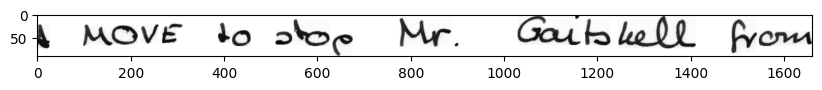

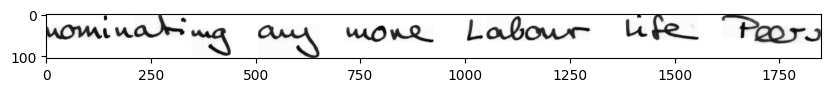

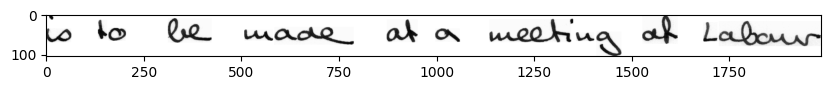

In [15]:
# All file-names list and target-writer names list are created.
tmp = []
target_list = []
tempDict = {}
tempDict = d.copy()
print(tempDict)
path_to_files = os.path.join('gdrive/My Drive/DataIAMFormSmall', '*')
for filename in sorted(glob.glob(path_to_files)):
#     print(filename)
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    #print(image_name)
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    #print("Form Image :: ", form)
    tempDict = d.copy()
    for key in d.keys():
        print("Keys:: ",key , "  :: Form : ", form)
        if key == form:
            val = tempDict.get(key)
            if val:
               #print("Form mapped with key :: ", key, " :: ", str(val))
               target_list.append(str(val))
               del tempDict[key]
    #print(target_list)

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
#print(img_targets)
#print(img_files)
print(img_files.shape)
print(img_targets.shape)

# visualize the image data
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

In [ ]:
# normalisation is done using label encoder. No, categorical data.
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:10], img_targets[:10], encoded_Y[:10])

In [ ]:
# Splitting of data into training and validation sets for cross validation with 4:1:1 ratio.
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

In [ ]:
# Generator function for generating random crops from each sentence randomly cropping 113*113 patches from images

batch_size = 8
num_classes = 7

def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)


            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train, y_train)

# For training and testing, generator function is called with the intent of making train and test generator data.
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)


In [19]:
# A Keras Model is built. Summary of the model is printed below.
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize(image,[56,56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image))  #resize images to allow for easy computation
#model.add(Lambda(lambda x: resize_image))

# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters=128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes
print("Worked till here")

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

print(model.summary())


Worked till here
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_1 (ZeroPadd  (None, 115, 115, 1)       0         
 ing2D)                                                          
                                                                 
 lambda_1 (Lambda)           (None, 56, 56, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 32)        832       
                                                                 
 activation_6 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                     

In [20]:
nb_epoch = 2
samples_per_epoch = 8
nb_val_samples = 62
from keras.callbacks import ModelCheckpoint
filepath="gdrive/My Drive/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

In [22]:
# #Model fit generator
 # Older Version history_object = model.fit_generator(train_generator, samples_per_epoch= samples_per_epoch,
   #                                   validation_data=validation_generator,
    #                                  nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, verbose=1, callbacks=callbacks_list)
history_object = model.fit_generator(train_generator,
                                     steps_per_epoch=samples_per_epoch,
                                      validation_data=validation_generator,
                                      validation_steps=nb_val_samples,
                                     epochs=nb_epoch, verbose=1,
                                     callbacks=callbacks_list)

<ipython-input-22-febd8a021ea1>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_object = model.fit_generator(train_generator,
<ipython-input-18-31d5645396a0>:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


Epoch 1/2
8/8 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9994
Epoch 1: saving model to gdrive/My Drive/check-01-0.0000.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 276s 38s/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
8/8 [==============================] - ETA: 0s - loss: 9.2809e-05 - accuracy: 0.9999
Epoch 2: saving model to gdrive/My Drive/check-02-0.0000.hdf5
8/8 [==============================] - 274s 38s/step - loss: 9.2809e-05 - accuracy: 0.9999 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [23]:
"""### Performance Metrics

Let's now test our model for calculating accuracy.
"""

model.load_weights('gdrive/My Drive/check-02-0.0000.hdf5')
scores = model.evaluate_generator(test_generator,121) # 121 is the number of test images.
print("Accuracy = ", scores[1] , " ::" , len(scores))

<ipython-input-23-a5a5eb3cb134>:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator,121) # 121 is the number of test images.
<ipython-input-18-31d5645396a0>:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


Accuracy =  1.0  :: 2


In [24]:
"""Load in test data."""

images = []
for filename in test_files[:50]:
     im = Image.open(filename)

     cur_width = im.size[0]
     cur_height = im.size[1]

     print("Before Crop:", cur_width, cur_height)
     height_fac = 113 / cur_height

     new_width = int(cur_width * height_fac)
     size = new_width, 113

     imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
     now_width = imresize.size[0]
     now_height = imresize.size[1]
     print("After Crop:", now_width, now_height)


Before Crop: 1989 96
After Crop: 2341 113
Before Crop: 1718 85
After Crop: 2283 113
Before Crop: 1875 92
After Crop: 2302 113
Before Crop: 1966 88
After Crop: 2524 113
Before Crop: 1205 78
After Crop: 1745 113
Before Crop: 1878 81
After Crop: 2619 113
Before Crop: 319 54
After Crop: 667 113
Before Crop: 2070 112
After Crop: 2088 113
Before Crop: 1886 106
After Crop: 2010 113
Before Crop: 1990 86
After Crop: 2614 113
Before Crop: 1815 73
After Crop: 2809 113
Before Crop: 1818 104
After Crop: 1975 113
Before Crop: 1741 77
After Crop: 2554 113
Before Crop: 475 62
After Crop: 865 113
Before Crop: 1106 69
After Crop: 1811 113
Before Crop: 449 66
After Crop: 768 113
Before Crop: 1759 75


<ipython-input-24-eeb06746fe88>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


After Crop: 2650 113
Before Crop: 1768 78
After Crop: 2561 113
Before Crop: 1868 79
After Crop: 2671 113
Before Crop: 1044 68
After Crop: 1734 113
Before Crop: 1885 98
After Crop: 2173 113
Before Crop: 1850 105
After Crop: 1990 113
Before Crop: 610 52
After Crop: 1325 113
Before Crop: 1935 76
After Crop: 2877 113
Before Crop: 1993 89
After Crop: 2530 113
Before Crop: 806 84
After Crop: 1084 113
Before Crop: 1956 84
After Crop: 2631 113
Before Crop: 1037 83
After Crop: 1411 113
Before Crop: 1617 82
After Crop: 2228 113
Before Crop: 1932 78
After Crop: 2798 113
Before Crop: 1968 68
After Crop: 3270 113
Before Crop: 1830 61
After Crop: 3390 113
Before Crop: 1922 73
After Crop: 2975 113
Before Crop: 606 67
After Crop: 1022 113
Before Crop: 1375 70
After Crop: 2219 113
Before Crop: 1912 74
After Crop: 2919 113
Before Crop: 1847 77
After Crop: 2710 113
Before Crop: 644 61
After Crop: 1192 113
Before Crop: 289 90
After Crop: 362 113
Before Crop: 565 79
After Crop: 808 113
Before Crop: 850 72


In [25]:
#     # Generate crops of size 113x113 from this resized image and keep random 10% of crops

avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

#     # Pick random x%
factor = 0.1
pick_num = int(len(avail_x_points)*factor)
print("Pick Number is ::", pick_num)

random_startx = sample(avail_x_points,  pick_num)

for start in random_startx:
    imcrop = imresize.crop((start, 0, start+113, 113))
    images.append(np.asarray(imcrop))

X_test = np.array(images)

X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
#     #convert to float and normalize
X_test = X_test.astype('float32')
X_test /= 255
shuffle(X_test)

print(X_test.shape)


Pick Number is :: 185
(185, 113, 113, 1)


6/6 [==============================] - 0s 17ms/step
(185, 7)
185


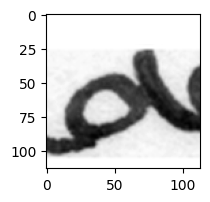

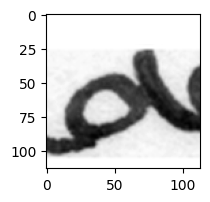

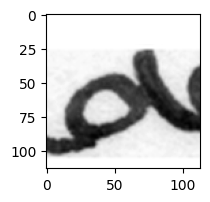

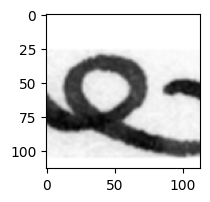

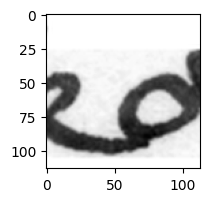

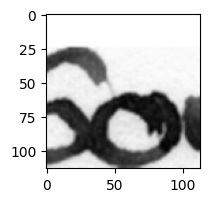

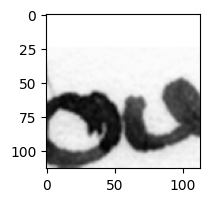

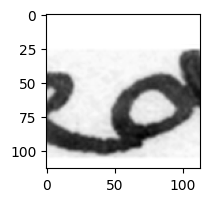

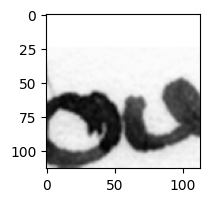

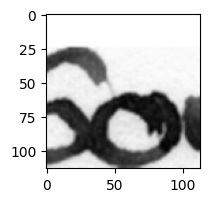

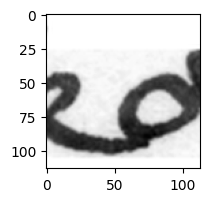

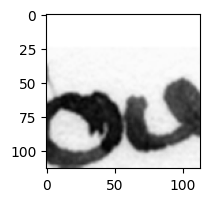

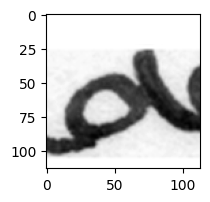

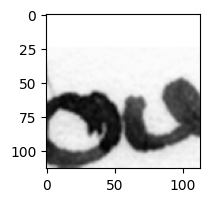

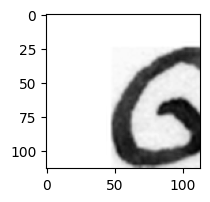

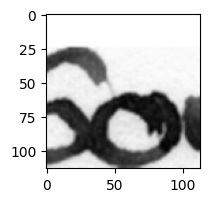

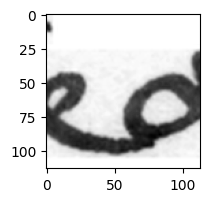

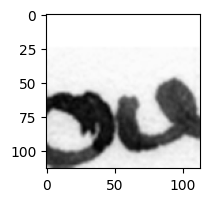

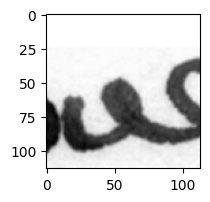

In [26]:
"""### Predictions"""

predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
     predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

"""### Insights"""

writer_number = 0
total_images =10
counter = 0
for i in range(len(predicted_writer)//10):
    # print("okay1" + " " +  str(predicted_writer[i]) )
     if predicted_writer[i] == writer_number:
         image = X_test[i].squeeze()
         plt.figure(figsize=(2,2))
         plt.imshow(image, cmap ='gray')
image = X_test[18].squeeze()
plt.figure(figsize=(2,2))
plt.imshow(image, cmap ='gray')


In [27]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [28]:
acc = history_object.history['accuracy']
val_acc = history_object.history['val_accuracy']
loss = history_object.history['loss']
val_loss = history_object.history['val_loss']
epochs = range(1,len(loss)+1)

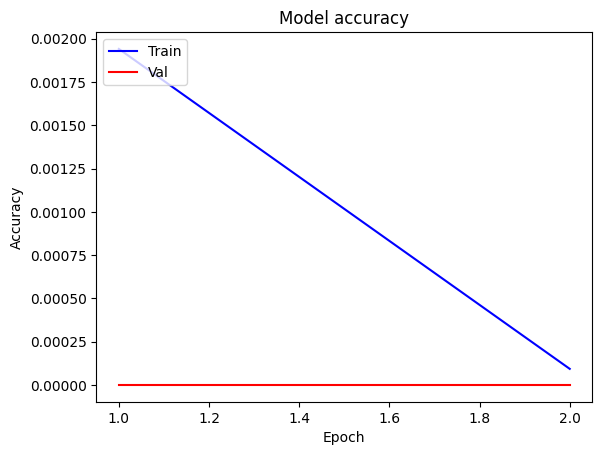

In [29]:
plotgraph(epochs, loss, val_loss)

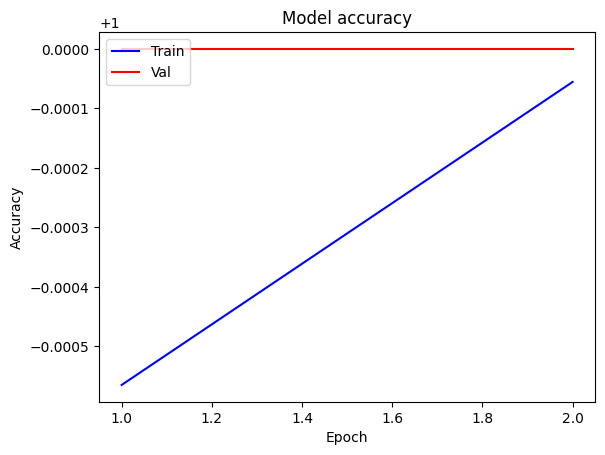

In [30]:
plotgraph(epochs, acc, val_acc)